In [1]:
#!/usr/bin/env python
import numpy as np
import scipy.interpolate
import numpy as np
import copy
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
def shift_elements(arr, num, fill_value):
    """"shifting function, with a fill value;
        if just want to "roll it" use np.roll"""
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [3]:
def vertinterpolate(var,lev, zlev_int,method=None):
    """Interpolate data unified 0.5 km vertical levels. (except in the first km)

    The default uses numpy interp, but scipy interp1d can also be
    chosen via method="scipy". Scipy interp1d however is much slower."""

    #import xarray as xr
    import numpy as np
    from scipy import interpolate

    var_int = np.zeros((len(zlev_int)))

    # loop over requested variables
    if method == "scipy":
        f_int = interpolate.interp1d(lev[:], var[:], bounds_error=False, kind="linear", fill_value="nan")
        var_int[:] = f_int(zlev_int)
    else:
        var_int[:] = np.interp(zlev_int[:], lev[:], var[:])



    return var_int

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = np.nanargmin(np.abs(array - value))
    return idx #array[idx]

In [5]:
def satvpw(T, param='murphykoop'):
    '''
    calculates saturation vapour pressure over water (hPa)
    using the Flatau et al., 1992 functions or
    GoffGratch or MurphyKoop functions (iCESM)
    '''

    if np.min(T) < 50:
      Ttr = 0
      Tk = T + 273.15
    else:
      Ttr = 273.15
      Tk = T

    if param == 'flatau':
        a1 = 6.11176750
        a2 = 0.443986062
        a3 = 0.143053301e-01
        a4 = 0.265027242e-03
        a5 = 0.302246994e-05
        a6 = 0.203886313e-07
        a7 = 0.638780966e-10

        esw = a1 + a2*(T-Ttr) + a3*(T-Ttr)**2 + a4*(T-Ttr)**3 + a5*(T-Ttr)**4     \
            + a6*(T-Ttr)**5 + a7*(T-Ttr)**6

    elif param == 'goffgratch':
        # uncertain below -70 C
        Tboil = 373.16
        esw = 10.**(-7.90298*(Tboil/Tk-1.)+ \
              5.02808*np.log10(Tboil/Tk)- \
              1.3816e-7*(10.**(11.344*(1.-Tk/Tboil))-1.)+ \
              8.1328e-3*(10.**(-3.49149*(Tboil/Tk-1.))-1.)+ \
              np.log10(1013.246))

    elif param == 'murphykoop':
        # (good for 123 < T < 332 K)
        esw = np.exp(54.842763 - (6763.22 / Tk) - (4.210 * np.log(Tk)) + \
              (0.000367 * Tk) + (np.tanh(0.0415 * (Tk - 218.8)) * \
              (53.878 - (1331.22 / Tk) - (9.44523 * np.log(Tk)) + \
              0.014025 * Tk))) / 100.

    return esw

def satvpi(T, param='murphykoop'):
    '''
    calculate saturation vapour pressure over ice (hPa)
    using the Flatau et al., 1992 functions or
    GoffGratch or MurphyKoop functions (iCESM)
    '''

    if np.min(T) < 50:
      Ttr = 0
      Tk = T + 273.15
    else:
      Ttr = 273.15
      Tk = T

    if param == 'flatau':
        a1=6.10952665
        a2=0.501948366
        a3=0.186288989e-01
        a4=0.403488906e-03
        a5=0.539797852e-05
        a6=0.420713632e-07
        a7=0.147271071e-09

        esi = a1 + a2*(T-Ttr) + a3*(T-Ttr)**2 + a4*(T-Ttr)**3 + a5*(T-Ttr)**4       \
             + a6*(T-Ttr)**5 + a7*(T-Ttr)**6

    elif param == 'goffgratch':
        h2otrip = 273.16

        esi = 10.**(-9.09718*(h2otrip/Tk-1.)-3.56654* \
           np.log10(h2otrip/Tk)+0.876793*(1.-Tk/h2otrip)+ \
           np.log10(6.1071)) #*100.

    elif param == 'murphykoop':
        esi = np.exp(9.550426 - (5723.265 / Tk) + (3.53068 * np.log(Tk)) \
                     - (0.00728332 * Tk)) / 100.

    return esi

In [6]:
#----------------------------------------------------------------------------------------
def dry_moistad_wice(T_0=293.15,p_0=1000.,fstop=0.2,zstop=40000.,dz=50.,rh_factor=1.,zstop_dry=500.):
    '''simulates pressure, temperature and humidity of an air parcel 
       during a moist adiabatic ascent starting at T_0 (K) and p_0 (hPa)
       stopping when f = fstop
       discretised with height steps of dz (m)
    '''

    g = 9.81         # gravitational acceleration
    cp = 1005.       # specific heat of dry air
    #Hv = 2257000.    # heat of vaporisation of water
    Hv = 2501000.    # from wiki and metpy
    Rd = 287.        # specific gas constant of dry air
    lamb = 0.004     # supersaturation tuning parameter => isotopes
    Tmmin = 238.15 #-35   # minimum temperature for mixed phase clouds
    Tmmax = 263.15 #-20   #273.15   # maximum temperature for mixed phase clouds
    #zstop_dry = 750 #dry adiabat from surface to 750 m, than moist 
    
    # supersaturation over ice and fr_liq as function of temp ###particularly relevant for isotopes
    T_ice = np.arange(99,Tmmin+0.1,0.1)
    T_liq = np.arange(Tmmax,399,0.1)
    Si_ice = 1. - lamb * (T_ice - Tmmax)
    #Si_ice = satvpi(alltemp)
    Si_liq = satvpw(T_liq)/satvpi(T_liq)
    Si_int = scipy.interpolate.InterpolatedUnivariateSpline(
        np.concatenate((T_ice,T_liq)),np.concatenate((Si_ice,Si_liq)),k=2) #quadratic interpolation
    fr_liq_ice = np.zeros(len(T_ice))
    fr_liq_liq = np.ones(len(T_liq))
    fr_liq_int = scipy.interpolate.InterpolatedUnivariateSpline(
        np.concatenate((T_ice,T_liq)),np.concatenate((fr_liq_ice,fr_liq_liq)),k=2) #quadratic interpolation
    #-----------

    # initialisation
    T_range = 1. / (Tmmax - Tmmin + 1e-16)
    k = 0
    z1 = 0.
    z = [0.]
    p = [p_0]
    T = [T_0]
    fr_liq = [fr_liq_int(T_0)]
    ewi = [fr_liq[0]*satvpw(T_0) + (1-fr_liq[0])*Si_int(T_0)*satvpi(T_0)] #sat mix pressure over water or ice depending on where we are
    wv = [ rh_factor * 0.622 * ewi[0] / (p_0 - ewi[0])]  #vapor saturation mixing ratio - saturated if rh_factor =1, BG added rh_factor!!!
    q = [wv[0] / (1 + wv[0]) * 1000.]   #??? for isotopes
    f = 1.

    Hvall = [(2.5 * 10**6) - (2.37 * 10**3)*(T_0 - 273.15)]
    Lapse_all = [0.]
    Lapsem_all = [0.]
    Lapsed_all = [0.]
    # dry adiabatic lapse rate
    L_d = g / cp

    #while f > fstop: #based on moisture
    #######BG HERE ONLY FOR DRY ADIABAT########################
    while z1 < zstop_dry: 
        z.append(z[k] + dz)
        #Told = T[k]
        Hv = (2.5 * 10**6) - (2.37 * 10**3)*(T[k] - 273.15)
        # dry adiabatic lapse rate

        T.append(T[k] - L_d*dz)
        p.append(p[k] * (T[k+1]/T[k]) ** (g/(Rd*L_d)))

        
        #only water considered for dry adiabat, we are at warm temp
        ewi.append(satvpw(T[k+1],'murphykoop'))
        #ewi.append(fr_liq[k+1]*satvpw(T[k+1]) + (1-fr_liq[k+1])*Si_int(T[k+1])*satvpi(T[k+1]))
        wv.append(0.622 * ewi[k+1] / (p[k+1] - ewi[k+1]) * rh_factor) #BG added rh_factor!!!
        q.append(wv[k+1] / (1 + wv[k+1]) * 1000.)
        
        Hvall.append(Hv)
        
        Lapsed_all.append(L_d) #BGBGBGB

        f = q[k+1]/q[0]
        z1 = z[k]
        k = k+1        
        
        fr_liq.append(1.0)
    ############HERE MOIST ADIABAT######################
    while z1 < zstop:
        z.append(z[k] + dz)
        #Told = T[k]
        Hv = (2.5 * 10**6) - (2.37 * 10**3)*(T[k] - 273.15)
        # moist adiabatic lapse rate
        L_m = L_d * (1 + Hv*wv[k]/(Rd*T[k]))/(1 + Hv**2*wv[k]*0.622/(cp*Rd*T[k]**2))
        #print(L_m)
        Lapsem_all.append(L_m)

        T.append(T[k] - L_m*dz)
        p.append(p[k] * (T[k+1]/T[k]) ** (g/(Rd*L_m)))

        #limit fr_liq between 1 and 0
        if (T[k+1]>Tmmax) or (fr_liq_int(T[k+1])>1.):
            fr_liq.append(1.0)
        elif (T[k+1]<Tmmin) or (fr_liq_int(T[k+1])<0.):
            fr_liq.append(0.0)
        else:
            fr_liq.append(fr_liq_int(T[k+1])) 

        #water and ice here
        ewi.append(fr_liq[k+1]*satvpw(T[k+1]) + (1-fr_liq[k+1])*Si_int(T[k+1])*satvpi(T[k+1]))
        #only water considered: increases T at anvil level by 1 K or so
        #ewi.append(satvpw(T[k+1],'murphykoop'))
        wv.append(0.622 * ewi[k+1] / (p[k+1] - ewi[k+1]) * rh_factor) #BG added rh_factor!!!
        q.append(wv[k+1] / (1 + wv[k+1]) * 1000.)

        Hvall.append(Hv)

        f = q[k+1]/q[0]
        z1 = z[k]
        k = k+1
    Lapsed_all = np.array(Lapsed_all)
    Lapsem_all = np.array(Lapsem_all)
    Lapse_all = np.array(Lapse_all)
    Lapse_all=np.concatenate((Lapsed_all,Lapsem_all[1:]),axis=0)
    return np.array(z),np.array(p),np.array(T),np.array(q),np.array(ewi),np.array(Lapse_all)#,np.array(Lapsem_all) #np.array(Hvall),np.array(wv/satvpw(T[k]))

In [7]:
#here compute the moist adiabatic lapse rate and T profile
#we start with T=293 because that fits better RCEMIP simulations than T=295K
#and in second step use the same logic for 305 K simulations; i.e. instead of starting at 305, we start at 303K 
moistadi_100_295 = dry_moistad_wice(T_0=293,p_0=1000.,fstop=0.0008,zstop=20000.,dz=50.,rh_factor=1,zstop_dry=600)
moistadi_100_305 = dry_moistad_wice(T_0=303,p_0=1000.,fstop=0.0008,zstop=20000.,dz=50.,rh_factor=1,zstop_dry=600)

Spectral Plume Model, based on Zhou and Xie, 2019 (10.1175/JAS-D-18-0330.1).

The code below was originally written in Matlab by Dennis L. Hartmann (University of Washington), and translated into python by Blaz Gasparini (University of Vienna)

Using also some bits and pieces of the code/basic thermodynamics and thermodynamical constants by Jiawei Bao/Bjorn Stevens (Max Planck Institute for Meterorology).

In [8]:
#useful constants for atmospheric thermodynamics--------
#copied from the aes_thermo_ice2.py script

"""
Created on Tuesday, May 22, 2019
Author: Bjorn Stevens (bjorn.stevens@mpimet.mpg.de)
"""
#
import numpy as np
from scipy import interpolate, optimize

gravity = 9.8076

cpd     = 1006.
Rd      = 287.05

Rv      = 461.53    # IAPWS97 at 273.15
cpv     = 1865.01   # ''
cpl     = 4219.32   # '' 
cpi     = 2096.70   # ''
lv0     = 2500.93e3 # ''
lf0     =  333.42e3 #''

eps1     = Rd/Rv
eps2     = Rv/Rd -1.


P0      = 100000.  # Standard Pressure [Pa]
T0      = 273.15   # Standard Temperature [K]
e0      = 611.2    # This is the saturation vapor pressure at T0 [K]
sd00    = 6783     # Dry air entropy at P0, T0
sv00    = 10321    # Water vapor entropy at P0, T0
PvC     = 22.064e6 # Critical pressure [Pa] of water vapor
TvC     = 647.096  # Critical temperature [K] of water vapor
TvT     = 273.16   # Triple point temperature [K] of water
PvT     = 611.655
#T_ice   = 233.15
T_ice   = 240.15 #below -33 C only ice

In [9]:
def e_sat(T):

    esl = PvT*(T/T0)**((cpv-cpl)/Rv)*np.exp( ( lv0 - T0*(cpv-cpl) )/Rv * ( 1./T0 - 1./T ) )
    esi = PvT*(T/T0)**((cpv-cpl)/Rv)*np.exp( ( lv0 + lf0 - T0*(cpv-cpl) )/Rv * ( 1./T0 - 1./T ) )
    
    fliq,fice = calc_fice(T)
    
    es = fliq*esl + fice*esi
    
    return es
    
def qq_sat(TK,PPa,qt=None) :

    Psat = e_sat(TK)
        
    rs = Rd/Rv * Psat/(PPa-Psat)
    
    if qt is not None:
        rt = qt/(1-qt)
        qs  = rs / (1+max(rt,rs))
    else:
        qs = rs/(1+rs)
    return qs


def calc_fice(T):

    fliq = (T-T_ice)/(T0-T_ice)
    fliq = np.where(fliq<0,0,fliq)
    fliq = np.where(fliq>1,1,fliq)
    fice = 1-fliq
    return fliq, fice

In [10]:
def PlumeModifiedEuler(h0, z, c, RHS):
    # initialize output
    h = np.zeros(len(z))
    # value of h at the surface
    h[0] = h0
    for k in range(1, len(z)):
        # predict the value h(k) using forward Euler
        h_eul = h[k-1] + (z[k]-z[k-1]) * (c[k-1]*h[k-1] + RHS[k-1])
        # Now use the trapezoidal rule to integrate from k-1 to k using h_eul in place of h(k)
        h[k] = h[k-1] + 0.5*(z[k]-z[k-1])*(c[k-1]*h[k-1] + RHS[k-1] + c[k]*h_eul + RHS[k])
    return h

In [11]:
#determine entrainment profile
def EPS(Z, params):
    #global ztop_conv
    # eps0=3.e-4;  # 0.3 km-1
    EPS = params["ent"] * ((ztop_conv - Z) / (ztop_conv - params["zb"])) ** params["entexp"]
    EPS[Z < params["zb"]] = 0.0
    EPS[Z > ztop_conv] = 0.0
    return EPS

In [12]:
def LAM(eps, z, params):
    #global ztop_conv
    # Comput Lambda for spectral plume model
    lam = -1.0 / ((ztop_conv - z) + eps * (ztop_conv - z) * (z - params["zb"]))
    lam[np.isnan(lam)] = 0.0
    lam[z < params["zb"]] = 0.0
    lam[z > ztop_conv] = 0.0
    lam = np.maximum(lam, -2e-2)
    return lam

In [13]:
def RHS(T, p, ent, params):
    # computes the right hand side of the spectral plume model
    # Pseudo moist adiabatic lapse rate calculator with entrainment E

    # Use Blossey script for constants and evaluation of ws
    g = 9.8
    Cp = 1005
    Rd = 287
    L = 2.5e6
    Ls = 3.34e5

    Eice=1
    # set water vapor amount based on RH profile
    if Eice == 1:
        rhs = -L * ent * (1 - rh_profile) * qq_sat(T,p) / Cp  # blended saturation
        #rhs = -L * ent * (1 - rh_profile) * satvpi(T - 273.18, p * 0.01) / Cp  # blended saturation
    else:
        #only liquid - modify it, dont have qsw_mk2005
        rhs = -L * ent * (1 - rh_profile) * qsw_mk2005(p, T) / Cp  # Liquid Saturation

    return rhs

In [14]:
#This code defines a Python class called "DefaultRCEParams". The class has a constructor method __init__() 
#which gets called automatically when an object of this class is created. 
#The constructor method initializes the object with a set of attributes

class DefaultRCEParams:
    def __init__(self):
        self.lapse1 = 5.0
        self.Psfc = 1013e2 # surface pressure in Pa
        self.ent = 3.0e-4 # Entrainment parameter for Spectral Plume Model
        self.entexp = 1.0
        self.zt = 16000.
        self.zb = 1000.

In [15]:
#calculate the 305 K SPM adjustment to the moist adiabatic lapse rate

#the interface for the SPM calculation of deviation from moist adiabatic lapse rate
ztop_conv = 14000  #14 km is best for 305, 11 km best for 295; best with RH = 80, and following fixed cloud base and entr param %
params = {
    'zb': 600,
    'ent': 3e-4, #=0.3 km-1
    'entexp': 1.0
}
#z = np.arange(0, 20001, 100)
z = moistadi_100_305[0]
levs = len(z)
rh = np.ones(levs) * 0.8
rh_profile = rh.T
#default profiles - change to sth more meaningful!
#pres = 1e5 * np.exp(z / 7600)
#Tatm = 300 - 5.0 * z / 1000

Tatm = moistadi_100_305[2]

pres = moistadi_100_305[1] * 100
L = 2.5e6
Cp = 1004
Rv = 461
g = 9.81
h0 = 0

qt = np.ones(levs)*0.

eps1 = EPS(z,params)
lam1 = LAM(eps1,z,params)
rhs1 = RHS(Tatm,pres,eps1,params)
h_plume = PlumeModifiedEuler(h0,z,lam1,rhs1)

cnstt = (L * L) / (Rv * Cp)
#bigfac = 1.0 + cnstt * qsat2(Tatm,pres) / Tatm / Tatm
bigfac = 1.0 + cnstt * qq_sat(Tatm,pres) / (Tatm * Tatm)
deltaT = h_plume / bigfac
deltaT305 = np.copy(deltaT) #305 K temperature profiles here

/tmp/ipykernel_2948839/3538228680.py:4: RuntimeWarning: divide by zero encountered in true_divide
  lam = -1.0 / ((ztop_conv - z) + eps * (ztop_conv - z) * (z - params["zb"]))


In [16]:
#calculate the 295 K SPM adjustment to the moist adiabatic lapse rate

#the interface for the SPM calculation of deviation from moist adiabatic lapse rate
ztop_conv = 11000  #14 km is best for 305, 11 km best for 295; best with RH = 80, and following fixed cloud base and entr param %
params = {
    'zb': 600,
    'ent': 3e-4, #=0.3 km-1
    'entexp': 1.0
}
z = moistadi_100_295[0]
levs = len(z)
rh = np.ones(levs) * 0.8
rh_profile = rh.T

Tatm = moistadi_100_295[2]

pres = moistadi_100_295[1] * 100
L = 2.5e6
Cp = 1004
Rv = 461
g = 9.81
h0 = 0
qt = np.ones(levs)*0.

eps1 = EPS(z,params)
lam1 = LAM(eps1,z,params)
rhs1 = RHS(Tatm,pres,eps1,params)
h_plume = PlumeModifiedEuler(h0,z,lam1,rhs1)

cnstt = (L * L) / (Rv * Cp)
bigfac = 1.0 + cnstt * qq_sat(Tatm,pres) / (Tatm * Tatm)
deltaT = h_plume / bigfac
deltaT295 = np.copy(deltaT) #295 K temperature profiles here

/tmp/ipykernel_2948839/3538228680.py:4: RuntimeWarning: divide by zero encountered in true_divide
  lam = -1.0 / ((ztop_conv - z) + eps * (ztop_conv - z) * (z - params["zb"]))


In [17]:
#load the RCEMIP processed data
path = '../../data/RCEMIP_processed/'

ssts = ['295','300','305']
#ssts = ['300']
col = ['k','orange','crimson']

plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other

variables = ['temperature']
units = ['K/day','K/day','1','kg/kg','kg/kg']
units = ['K/day','K/day','K/day','1','kg/m3','kg/kg']

ds1 = xr.open_dataset(path+'RCElarge_z24_merged_1D_averages_multiplevars2.nc')

Before doing the prediction, we regrid onto a finer, 50 m vertical grid, same as already done in the characterization and attribution steps

In [18]:
# target vertical levels
zlev_int = np.arange(0, 24.001, 0.05) #50 m 
ssts = ['295','300','305']
models = ['MESONH','NICAM','SAM_CRM','SAM_GCRM','SCALE','dam','MPAS','UCLA-CRM','CAM5_GCM',
          'CAM6_GCM','CNRM-CM6-1','GEOS_GCM','ICON_LEM_CRM','ICON_NWP_CRM','SP-CAM','SPX-CAM','UKMO-GA7.1','CM1']
variables = ['hr_acre','ice_mixing_ratio','cloud_fraction','density','temperature']
#1.) filter and regrid ACRE 
dataint={}  
ds1['ice_water_content'] = ds1['ice_mixing_ratio']*ds1['density']
data_ice={}
data_temp={}
for v,variable in enumerate(variables):
    dataint[variable]={}
    for m,model in enumerate(models):
        #print(model)
        dataint[variable][model]={}
        data_ice[model]={}
        data_temp[model]={}
        for s,sst in enumerate(ssts):
            dataint[variable][model][sst]={}
            data_ice[model][sst]={}
            data_temp[model][sst]={}
            rho0=ds1['density'][m][s].values
            temp0 = ds1['temperature'][m][s].values        
            ice0=ds1['ice_mixing_ratio'][m][s].values*rho0   

            plotvar = (ds1[variable][m,s]).values

            if variable=='density':
                pass
            else:
                #only for T<0 => upper troposphere
                #only where there is ice present (avoid stratosphere)
                plotvar[temp0>273.15] = 0. #np.nan
                plotvar[ice0<1.e-8] = 0. #np.nan                

            acre_interp = vertinterpolate(plotvar,ds1['alt'].values,zlev_int,method='scipy')
            dataint[variable][model][sst]=acre_interp

            ice_interp = vertinterpolate(ice0,ds1['alt'].values,zlev_int,method='scipy')
            temp_interp = vertinterpolate(temp0,ds1['alt'].values,zlev_int,method='scipy')

            data_ice[model][sst] =ice_interp

            data_temp[model][sst]=temp_interp

In [19]:
temp_anom_best = np.zeros(len(models))
alt_cold = np.zeros(len(models))
temp_cold= np.zeros(len(models))
alt_warm = np.zeros(len(models))
isot_alt_shift = np.zeros(len(models))
isot_alt_shift_adiab = np.zeros(len(models))

#dens_cold=np.zeros(len(models))
#dens_fac = np.zeros(len(models))

alt_cold_ad = np.zeros(len(models))
alt_warm_ad = np.zeros(len(models))

for m,model in enumerate(models):
    print(m,model)
    alt_cold[m] = np.nanargmax(dataint['hr_acre'][model]['295'])*50 #alt in m (spacing is 50 m)
    temp_cold[m] = dataint['temperature'][model]['295'][np.nanargmax(dataint['hr_acre'][model]['295'])]

    temp_anom_best[m]= dataint['temperature'][model]['305'][np.nanargmax(dataint['hr_acre'][model]['305'])] - dataint['temperature'][model]['295'][np.nanargmax(dataint['hr_acre'][model]['295'])]

    alt_warm[m] = find_nearest(dataint['temperature'][model]['305'],temp_cold[m]) * 50 #alt in meters
    isot_alt_shift[m] = alt_warm[m] - alt_cold[m]
    #NOTE: moistadi_100_295[2]+deltaT295 = outcome of Spectral Plume Model

    alt_cold_ad[m] = find_nearest(moistadi_100_295[2]+deltaT295,temp_cold[m]) * 50
    alt_warm_ad[m] = find_nearest(moistadi_100_305[2]+deltaT305,temp_cold[m]) * 50
    isot_alt_shift_adiab[m] = alt_warm_ad[m] - alt_cold_ad[m]

0 MESONH
1 NICAM
2 SAM_CRM
3 SAM_GCRM
4 SCALE
5 dam
6 MPAS
7 UCLA-CRM
8 CAM5_GCM
9 CAM6_GCM
10 CNRM-CM6-1
11 GEOS_GCM
12 ICON_LEM_CRM
13 ICON_NWP_CRM
14 SP-CAM
15 SPX-CAM
16 UKMO-GA7.1
17 CM1


In [20]:
ph_cold_s3 = np.zeros((len(models),481)) # shifted CRH profile using physical predictive method

densfac_all= np.zeros((len(models),481)) # density factor using physical predictive method
cold_all= np.zeros((len(models),481)) # density factor using physical predictive method
warm_all= np.zeros((len(models),481)) # density factor using physical predictive method


rms = np.zeros(len(models))
rms_shift_ad = np.zeros(len(models))
rms_densfac_ad = np.zeros(len(models))
rms_dens_iris_ad = np.zeros(len(models))

e_shift_ad = np.zeros(len(models))
e_densfac_ad = np.zeros(len(models))
e_dens_iris_ad = np.zeros(len(models))

rms_all = np.zeros((len(models),2))
e_all = np.zeros((len(models),2))
e_all_expl = np.zeros((len(models),2))

for m,model in enumerate(models):
    #print(m,model)
    cold = dataint['hr_acre'][model]['295']
    cold_all[m,:] = cold
    warm = dataint['hr_acre'][model]['305']
    warm_all[m,:] = warm

    #here done based on physical assumptions of isothermal shift
    index3 = int(isot_alt_shift_adiab[m]/50 )
    ph_cold_s=shift_elements(cold,index3,0) 
    ph_cold_s3[m]=ph_cold_s

    dens_shift3=shift_elements(dataint['density'][model]['295'],index3,0)
    densfac3=dens_shift3/dataint['density'][model]['295'] 
    densfac_all[m,:] = densfac3

    #RMS basic:
    rms[m]      =np.nansum( np.sqrt((warm-cold)**2) ) #FULL RMS, later looking at fraction of this explained by moist adiabats

    #RMS of the  moist adiabatic shift only: our starting point
    rms_shift_ad[m]=np.nansum( np.sqrt((warm-ph_cold_s3[m])**2) )
    e_shift_ad[m]=100-np.round(100*rms_shift_ad[m]/rms[m],1)

    #RMS of shift+ density factor
    rms_densfac_ad[m]=np.nansum( np.sqrt((warm-ph_cold_s3[m]*densfac3)**2) )
    e_densfac_ad[m]=100-np.round(100*rms_densfac_ad[m]/rms[m],1)

    e_all_expl[m] = [e_shift_ad[m], e_densfac_ad[m]]

Here figure Extended data 3. The averages, stated also in the plot, are used for Fig. 3c

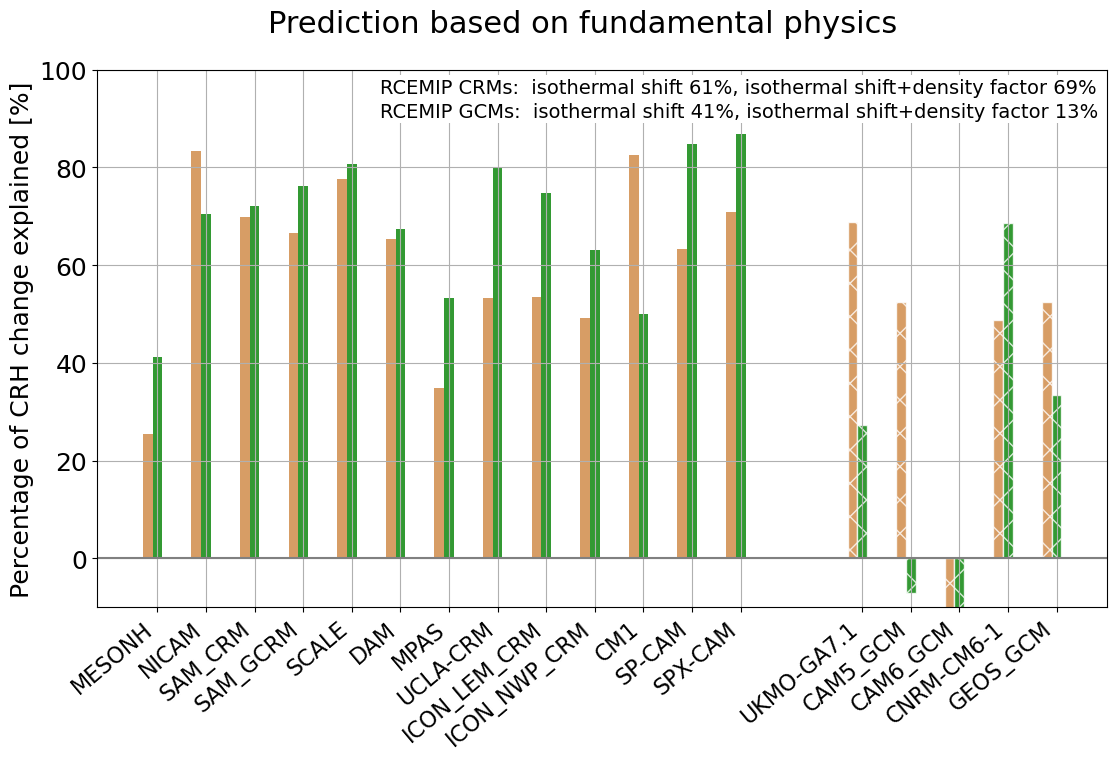

In [21]:
varnames = ['explained_isoth_shift','explained_isoshift_dens','explained_isoshift_iris']
cols = ['peru','g']

mmm = np.array(['MESONH','NICAM','SAM_CRM','SAM_GCRM','SCALE','DAM','MPAS','UCLA-CRM','CAM5_GCM',
            'CAM6_GCM','CNRM-CM6-1','GEOS_GCM','ICON_LEM_CRM','ICON_NWP_CRM','SP-CAM','SPX-CAM','UKMO-GA7.1','CM1'])
idx = [0,1,2,3,4,5,6,7,12,13,17,14,15,16,8,9,10,11]
models = mmm[idx]

e_all_expl_shift = np.copy(e_all_expl)
e_all_expl_shift = e_all_expl_shift[idx]
fig = plt.figure()

fig.set_size_inches(12,8,forward=True)
gs = gridspec.GridSpec(1,1,height_ratios=[1],width_ratios=1*[1])

ax = fig.add_subplot(gs[0,0])

x_pos = np.arange(len(models)+4)
mod_xpos=np.concatenate((x_pos[:13], [14.5,15.5,16.5,17.5,18.5]), axis=0)

for m in range(0,len(models)):
    if m<(len(models)-5): #CRMs
        plt.bar(mod_xpos[m],e_all_expl_shift[m,0],color=cols[0],width=0.2,alpha=0.8,label=model)#
        plt.bar(mod_xpos[m]+0.2,e_all_expl_shift[m,1],color=cols[1],width=0.2,alpha=0.8)  #shift+int
    if m in (13,14,15,16,17): #GCMs 
        plt.bar(mod_xpos[m],e_all_expl_shift[m,0],color=cols[0],width=0.2,alpha=0.8,hatch='x',ec='w')#
        plt.bar(mod_xpos[m]+0.2,e_all_expl_shift[m,1],color=cols[1],width=0.2,alpha=0.8,hatch='x',ec='w')  #shift+int

ax.set_xticks(mod_xpos+0.2, models, rotation=40, ha='right',size=16)


plt.text(0.28,0.94,'RCEMIP GCMs:  isothermal shift 41%, isothermal shift+density factor 13%',transform=ax.transAxes,horizontalalignment='left',
verticalalignment='top',fontsize=14,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=2))

plt.text(0.28,0.985,'RCEMIP CRMs:  isothermal shift 61%, isothermal shift+density factor 69%',transform=ax.transAxes,horizontalalignment='left',
verticalalignment='top',fontsize=14,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=2))

plt.axhline(y=0,color='gray')
plt.ylabel('Percentage of CRH change explained [%]')

plt.ylim(-10,100)
plt.suptitle('Prediction based on fundamental physics',fontsize=22,y=0.96)
plt.grid(True)
plt.tight_layout()
#plt.savefig('/path-to-file/FigEXT4_PREDICTION_shift_explained_RCElarge_SPM+adiabats.pdf',bbox_inches='tight')  